In [1]:
import os, sys
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

In [2]:
import GCRCatalogs
sys.path.insert(0, '../sims_GCRCatSimInterface/python/desc/sims/GCRCatSimInterface')
from AGNModule import M_i_from_L_Mass, log_Eddington_ratio, k_correction, tau_from_params, SF_from_params
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, BandpassDict, Bandpass, CosmologyObject
from lsst.sims.utils import findHtmid

In [60]:
from agn_modules import create_k_corr_grid, get_m_i, unravel_dictcol, join_catalogs, add_columns

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
agn_db = os.path.join('/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/agn_db_mbh7_mi30_sf4.db')

# Read in the AGN database
conn = sqlite3.connect(agn_db)

# See which tables the db file has
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('agn_params',)]


In [79]:
%%time 
# Generator containing the agn_params table as a Pandas DataFrame
agn_df_gen = pd.read_sql(sql='SELECT * from agn_params', con=conn, chunksize=200000)

CPU times: user 732 µs, sys: 824 µs, total: 1.56 ms
Wall time: 77.8 ms


In [80]:
%%time
agn_chunks = list(agn_df_gen)

CPU times: user 52.8 s, sys: 11.6 s, total: 1min 4s
Wall time: 1min 4s


In [52]:
%%time
# 35s in Jupyter-dev
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

CPU times: user 1.6 s, sys: 270 ms, total: 1.87 s
Wall time: 27.2 s


In [217]:
# Notebook-wide constants
colors_dict = {'u': 'purple', 'g': 'blue', 'r': 'green', 'i': 'orange', 'z': 'red'}

In [81]:
joined_dict = {}

In [82]:
%%time
for chunk_id in range(3):
    joined_dict[chunk_id] = join_catalogs(agn_chunks[chunk_id], cosmodc2)

(200000, 20)
Index(['mag_true_i_sdss', 'redshift', 'galaxy_id', 'mag_true_z_sdss',
       'blackHoleAccretionRate', 'mag_true_g_sdss', 'mag_true_u_sdss',
       'mag_true_r_sdss', 'blackHoleMass', 'blackHoleEddingtonRatio',
       'htmid_8', 'magNorm', 'seed', 'agn_tau', 'agn_sfu', 'agn_sfg',
       'agn_sfr', 'agn_sfi', 'agn_sfz', 'agn_sfy'],
      dtype='object')
(200000, 20)
Index(['mag_true_i_sdss', 'redshift', 'galaxy_id', 'mag_true_z_sdss',
       'blackHoleAccretionRate', 'mag_true_g_sdss', 'mag_true_u_sdss',
       'mag_true_r_sdss', 'blackHoleMass', 'blackHoleEddingtonRatio',
       'htmid_8', 'magNorm', 'seed', 'agn_tau', 'agn_sfu', 'agn_sfg',
       'agn_sfr', 'agn_sfi', 'agn_sfz', 'agn_sfy'],
      dtype='object')
(200000, 20)
Index(['mag_true_i_sdss', 'redshift', 'galaxy_id', 'mag_true_z_sdss',
       'blackHoleAccretionRate', 'mag_true_g_sdss', 'mag_true_u_sdss',
       'mag_true_r_sdss', 'blackHoleMass', 'blackHoleEddingtonRatio',
       'htmid_8', 'magNorm', 'seed', 'ag

In [83]:
joined_dict['combined'] = pd.concat(joined_dict.values(), axis=0)

In [84]:
combined = add_columns(joined_dict['combined'])

calculating valid dexes


In [85]:
# Query
M_i_neg27_to_neg26 = combined.query("(M_i > -27) & (M_i < -26)")
print(M_i_neg27_to_neg26.shape)
m_i_cut = combined.query("m_i < 22.5")
print(m_i_cut.shape)

(89, 27)
(9308, 27)


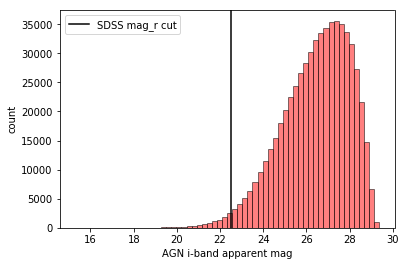

In [227]:
# Apparent magnitude dist

plt.hist(combined['m_i'], bins=60, edgecolor='black', color=colors_dict[b], alpha=0.5) #label=b + ": all")
#plt.xlim([0.0, 1.5])
#plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5], rotation=60)
plt.axvline(x=22.5, color='k', label="SDSS mag_r cut")
plt.ylabel("count")
plt.xlabel("AGN i-band apparent mag")
plt.legend()

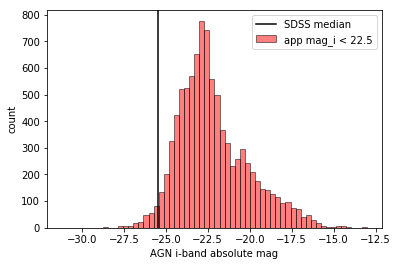

In [229]:
# Absolute magnitude dist

plt.hist(m_i_cut['M_i'], bins=60, edgecolor='black', color=colors_dict[b], alpha=0.5, label="app mag_i < 22.5")
#plt.xlim([0.0, 1.5])
#plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0, 1.5], rotation=60)
plt.axvline(x=-25.46, color='k', label="SDSS median")
plt.ylabel("count")
plt.xlabel("AGN i-band absolute mag")
plt.legend()

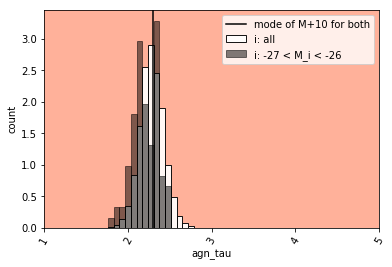

In [246]:
col_name = 'agn_tau'

_, bins, _ = plt.hist(np.log10(m_i_cut[col_name]), bins=20, edgecolor='black', color='w', alpha=0.9, label=b + ": all", normed=True)
_ = plt.hist(np.log10(M_i_neg27_to_neg26[col_name]), bins=bins, edgecolor='black', color='k', alpha=0.5, label=b + ": -27 < M_i < -26", normed=True)
plt.xlabel(col_name)
#plt.xlim([0.0, 1.5])
plt.xticks([1, 2, 3, 4, 5], rotation=60)
plt.axvline(x=2.3, color='k', label="mode of M+10 for both")
ax = plt.gca()
ax.set_facecolor('xkcd:pale salmon')
plt.ylabel("count")
plt.legend()

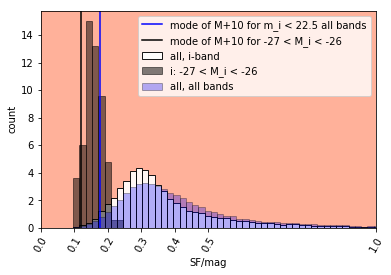

In [251]:
# SF_inf distribution
b = 'i'

SF_all_bands = np.concatenate([m_i_cut['agn_sf%s' %bp].values for bp in 'ugriz'])

_, bins, _ = plt.hist(m_i_cut['agn_sf%s' %b], bins=100, edgecolor='black', color='w', alpha=0.9, label="all, %s-band" %(b), density=True)
_ = plt.hist(M_i_neg27_to_neg26['agn_sf%s' %b], bins=bins, edgecolor='black', color='k', alpha=0.5, label=b + ": -27 < M_i < -26 ", density=True)
_ = plt.hist(SF_all_bands, bins=bins, edgecolor='black', color='b', alpha=0.3, label= "all, all bands", density=True)

plt.xlabel("SF/mag")
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0], rotation=60)
plt.axvline(x=0.175, color='blue', label="mode of M+10 for m_i < 22.5 all bands")
plt.axvline(x=0.12, color='k', label="mode of M+10 for -27 < M_i < -26")
plt.ylabel("count")
#plt.yscale('log', nonposy='clip')
ax = plt.gca()
ax.set_facecolor('xkcd:pale salmon')
plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

[2.38707211 0.25105267]


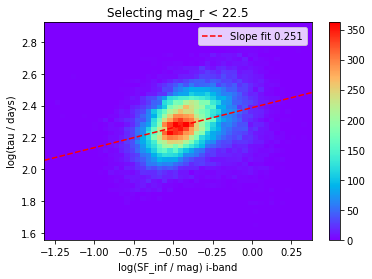

In [252]:
# tau vs. SF_inf

def tau_vs_SF_func(x, p0, p1):
    return p1*x + p0
p_init = [1.0, 1.3] # Initial guess for the parameters

b = 'i'
#x = np.log10(m_i_cut['agn_sf%s' %b].values)# SF_inf
#y =  np.log10(m_i_cut['agn_tau'].values)# tau
x = np.log10(SF_all_bands)
y = np.tile(np.log10(m_i_cut['agn_tau'].values), 5)
counts, ybins, xbins, image = plt.hist2d(x, y, bins=50, label=b, cmap = plt.cm.rainbow)
popt, success = optimize.curve_fit(tau_vs_SF_func, x, y, p_init[:])
print(popt)
x_grid = np.linspace(np.min(x), np.max(x), 100)
plt.plot(x_grid, tau_vs_SF_func(x_grid, *popt), 'r--', label='Slope fit %.3f' %(popt[1]))
    
plt.title("Selecting mag_r < 22.5")
#plt.gca().invert_yaxis()
plt.ylabel("log(tau / days)")
plt.xlabel("log(SF_inf / mag) %s-band" %b)
plt.legend()
plt.colorbar()
plt.show()

# tau vs. SF_inf
b = 'i'
#x = np.log10(m_i_cut['agn_sf%s' %b].values)# SF_inf
#y =  np.log10(m_i_cut['agn_tau'].values)# tau
x = np.log10(SF_all_bands)
y = np.tile(np.log10(m_i_cut['agn_tau'].values), 5)
counts, ybins, xbins = np.histogram2d(x, y, bins=50)
plt.contour(counts.transpose(), [0.2, 0.5, 0.7, 0.9], linewidths=3,colors='black',
    linestyles='solid')

#contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
plt.plot(x_grid, tau_vs_SF_func(x_grid, *popt), 'r--', label='Slope fit %.3f' %(popt[1]))
plt.title("Selecting mag_r < 22.5")
#plt.gca().invert_yaxis()
plt.ylabel("log(tau / days)")
plt.xlabel("log(SF_inf / mag) %s-band" %b)
plt.legend()
plt.colorbar()
plt.show()

/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:8: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.
/opt/lsst/software/stack/python/miniconda3-4.5.4/envs/lsst-scipipe-fcd27eb/lib/python3.6/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: The bivariate_normal function was deprecated in version 2.2.


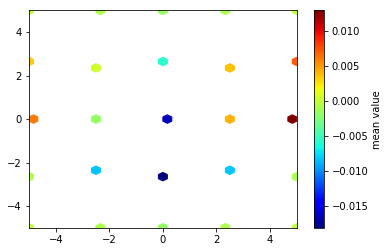

In [257]:
import matplotlib.mlab as ML
from matplotlib import pyplot as PLT
from matplotlib import cm as CM

n = 1e5
x = y = np.linspace(-5, 5, 5)
X, Y = np.meshgrid(x, y)
Z1 = ML.bivariate_normal(X, Y, 2, 2, 0, 0)
Z2 = ML.bivariate_normal(X, Y, 4, 1, 1, 1)
ZD = Z2 - Z1
x = X.ravel()
y = Y.ravel()
z = ZD.ravel()
gridsize=30
PLT.subplot(111)

# if 'bins=None', then color of each hexagon corresponds directly to its count
# 'C' is optional--it maps values to x-y coordinates; if 'C' is None (default) then 
# the result is a pure 2D histogram 

PLT.hexbin(x, y, C=z, gridsize=gridsize, cmap=CM.jet, bins=None)
PLT.axis([x.min(), x.max(), y.min(), y.max()])

cb = PLT.colorbar()
cb.set_label('mean value')
PLT.show()   

In [259]:
ZD

array([[-7.68101328e-05, -8.00381600e-04, -1.74819446e-03,
        -8.00381449e-04, -7.68099620e-05],
       [-7.72125072e-04, -8.28081768e-03, -1.81322510e-02,
        -8.25904422e-03, -7.47591097e-04],
       [ 6.08667157e-03, -1.75927439e-03, -1.63981447e-02,
         4.27790096e-03,  1.28892628e-02],
       [ 3.39331988e-03,  4.68805221e-04, -5.69652946e-03,
         3.70027233e-03,  7.03448460e-03],
       [-7.24769873e-05, -7.91279718e-04, -1.73525807e-03,
        -7.87940651e-04, -6.87145804e-05]])

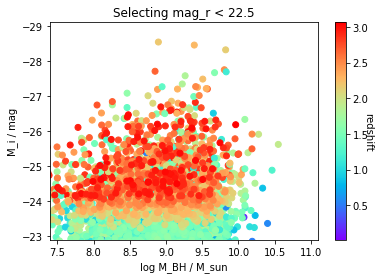

In [260]:
# M_i, bh mass, redshift

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10(m_i_cut['blackHoleMass'])
y = m_i_cut['M_i']
z = m_i_cut['redshift']
sc = plt.scatter(x, y, c=z, cmap=plt.cm.rainbow)
plt.title("Selecting mag_r < 22.5")

plt.ylabel("M_i / mag")
plt.ylim([ -29.1, -22.9,])
plt.gca().invert_yaxis()
plt.xlim([7.4, 11.1])
plt.xlabel("log M_BH / M_sun")
cbar = plt.colorbar()
cbar.ax.set_ylabel('redshift', rotation=270)
plt.show()

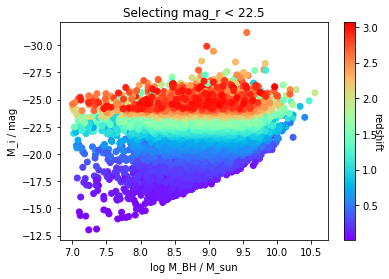

In [253]:
# M_i, bh mass, redshift

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10(m_i_cut['blackHoleMass'])
y = m_i_cut['M_i']
z = m_i_cut['redshift']
plt.scatter(x, y, c=z, cmap=plt.cm.rainbow)
plt.title("Selecting mag_r < 22.5")

plt.ylabel("M_i / mag")
plt.gca().invert_yaxis()
plt.xlabel("log M_BH / M_sun")
cbar = plt.colorbar()
cbar.ax.set_ylabel('redshift', rotation=270)
plt.show()

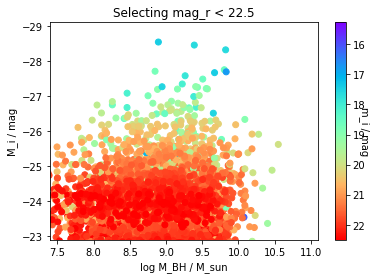

In [172]:
# M_i, bh mass, m_i

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10(m_i_cut['blackHoleMass'])
y = m_i_cut['M_i']
z = m_i_cut['m_i']
plt.scatter(x, y, c=z, cmap=plt.cm.rainbow)
plt.title("Selecting mag_r < 22.5")

plt.ylabel("M_i / mag")
plt.ylim([ -29.1, -22.9,])
plt.gca().invert_yaxis()
plt.xlim([7.4, 11.1])
plt.xlabel("log M_BH / M_sun")
cbar = plt.colorbar()
cbar.ax.set_ylabel('m_i / mag', rotation=270)
cbar.ax.invert_yaxis()
plt.show()

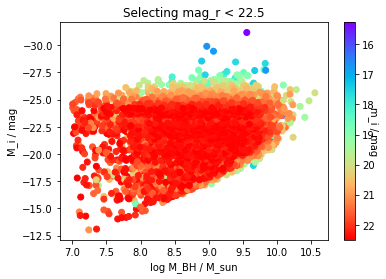

In [263]:
# M_i, bh mass, m_i

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10(m_i_cut['blackHoleMass'])
y = m_i_cut['M_i']
z = m_i_cut['m_i']
plt.scatter(x, y, c=z, cmap=plt.cm.rainbow)
plt.title("Selecting mag_r < 22.5")

plt.ylabel("M_i / mag")
plt.gca().invert_yaxis()
plt.xlabel("log M_BH / M_sun")
cbar = plt.colorbar()
cbar.ax.set_ylabel('m_i / mag', rotation=270)
cbar.ax.invert_yaxis()
plt.show()

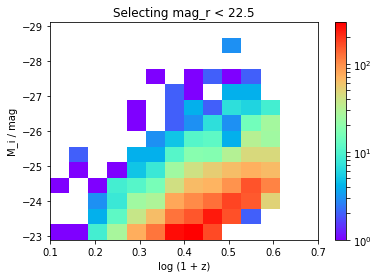

In [182]:
# M_i, redshift

from matplotlib.colors import LogNorm

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10((m_i_cut['redshift'].values + 1.0))
y = m_i_cut['M_i']
x_bins = np.linspace(0.1, 0.7, 15)
y_bins = np.linspace(-29.1, -22.9, 15)
counts, ybins, xbins, image = plt.hist2d(x, y, bins=(x_bins, y_bins), label=b, norm=LogNorm(), cmap=plt.cm.rainbow)
    #counts = (counts - np.min(counts))/(np.max(counts) - np.min(counts))
    #counts = counts/np.sum(counts)
    #plt.contour(counts.transpose(), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
    #plt.contour(counts.transpose(), extent=[-1.4, 0.0, 0.0, 4.1],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
plt.title("Selecting mag_r < 22.5")
plt.gca().invert_yaxis()
plt.ylabel("M_i / mag")
plt.xlabel("log (1 + z)")
cbar = plt.colorbar()
plt.show()

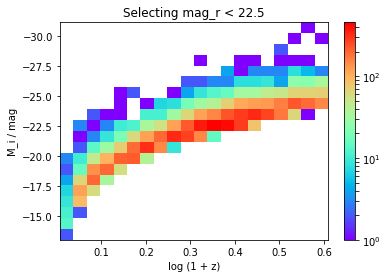

In [190]:
# M_i, redshift (zoomed-out version)

from matplotlib.colors import LogNorm

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10((m_i_cut['redshift'].values + 1.0))
y = m_i_cut['M_i']

counts, ybins, xbins, image = plt.hist2d(x, y, bins=20, label=b, norm=LogNorm(), cmap=plt.cm.rainbow)
    #counts = (counts - np.min(counts))/(np.max(counts) - np.min(counts))
    #counts = counts/np.sum(counts)
    #plt.contour(counts.transpose(), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
    #plt.contour(counts.transpose(), extent=[-1.4, 0.0, 0.0, 4.1],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
plt.title("Selecting mag_r < 22.5")
plt.gca().invert_yaxis()
plt.ylabel("M_i / mag")
plt.xlabel("log (1 + z)")
cbar = plt.colorbar()
plt.show()

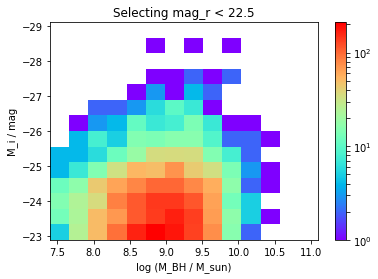

In [187]:
# M_i, bh mass

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10((m_i_cut['blackHoleMass'].values))
y = m_i_cut['M_i']
x_bins = np.linspace(7.4, 11.1, 15)
y_bins = np.linspace(-29.1, -22.9, 15)
counts, ybins, xbins, image = plt.hist2d(x, y, bins=(x_bins, y_bins), label=b, norm=LogNorm(), cmap=plt.cm.rainbow)
    #counts = (counts - np.min(counts))/(np.max(counts) - np.min(counts))
    #counts = counts/np.sum(counts)
    #plt.contour(counts.transpose(), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
    #plt.contour(counts.transpose(), extent=[-1.4, 0.0, 0.0, 4.1],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
plt.title("Selecting mag_r < 22.5")
plt.gca().invert_yaxis()
plt.ylabel("M_i / mag")
plt.xlabel("log (M_BH / M_sun)")
cbar = plt.colorbar()
plt.show()

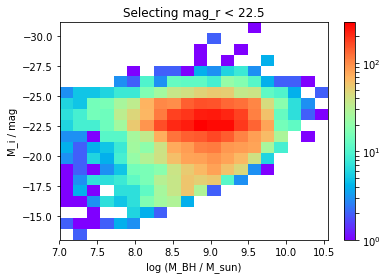

In [189]:
# M_i, bh mass (zoomed out version)

    #sf_inf = np.log10(test_1['agn_sf%s' %b].copy())
    #tau =  np.log10(test_1['agn_tau'].copy())
x = np.log10((m_i_cut['blackHoleMass'].values))
y = m_i_cut['M_i']
counts, ybins, xbins, image = plt.hist2d(x, y, bins=20, label=b, norm=LogNorm(), cmap=plt.cm.rainbow)
    #counts = (counts - np.min(counts))/(np.max(counts) - np.min(counts))
    #counts = counts/np.sum(counts)
    #plt.contour(counts.transpose(), extent=[xbins[0], xbins[-1], ybins[0], ybins[-1]],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
    #plt.contour(counts.transpose(), extent=[-1.4, 0.0, 0.0, 4.1],
    #linewidths=3, cmap = plt.cm.rainbow, levels = [0.2, 0.5, 0.7, 0.9], origin='lower')
plt.title("Selecting mag_r < 22.5")
plt.gca().invert_yaxis()
plt.ylabel("M_i / mag")
plt.xlabel("log (M_BH / M_sun)")
cbar = plt.colorbar()
plt.show()

In [207]:
x.shape

(9308,)

No handles with labels found to put in legend.


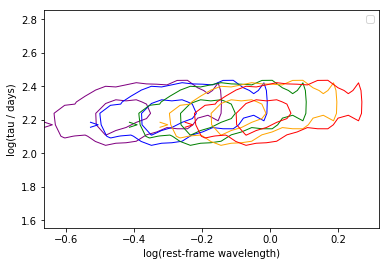

In [218]:
# tau vs. rest-frame wavelength
for b in 'ugriz':
    #x = np.log10(m_i_cut['agn_sf%s' %b].values)# SF_inf
    #y =  np.log10(m_i_cut['agn_tau'].values)# tau
    x = np.log10(m_i_cut['rf_%s' %b])
    y = np.log10(m_i_cut['agn_tau'])
    counts, xbins, ybins = np.histogram2d(x, y, bins=20)
    plt.contour(xbins[:-1], ybins[:-1], counts.transpose(), 2, linewidths=1, colors=colors_dict[b], linestyles='solid', label=b)
plt.ylabel("log(tau / days)")
plt.xlabel("log(rest-frame wavelength)")
plt.legend()

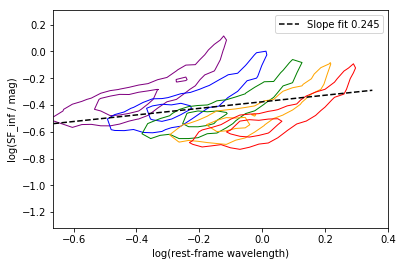

In [225]:
def sf_vs_wavelength(x, p0, p1):
    return p1*x + p0
p_init = [-0.479, -0.4] # Initial guess for the parameters

wavelengths_all_bands = np.concatenate([np.log10(m_i_cut['rf_%s' %b]).values for b in 'ugriz'])
SF_all_bands = np.concatenate([np.log10(m_i_cut['agn_sf%s' %b]).values for b in 'ugriz'])

popt, success = optimize.curve_fit(tau_vs_SF_func, wavelengths_all_bands, SF_all_bands, p_init[:])
x_grid = np.linspace(np.min(wavelengths_all_bands), np.max(wavelengths_all_bands), 100)
plt.plot(x_grid, sf_vs_wavelength(x_grid, *popt), 'k--', label='Slope fit %.3f' %(popt[1]))

# SF+omf vs. rest-frame wavelength
for b in 'ugriz':
    #x = np.log10(m_i_cut['agn_sf%s' %b].values)# SF_inf
    #y =  np.log10(m_i_cut['agn_tau'].values)# tau
    x = np.log10(m_i_cut['rf_%s' %b])
    y = np.log10(m_i_cut['agn_sf%s' %b])
    counts, xbins, ybins = np.histogram2d(x, y, bins=20)
    plt.contour(xbins[:-1], ybins[:-1], counts.transpose(), 2, linewidths=1, colors=colors_dict[b], linestyles='solid', label=b)
plt.ylabel("log(SF_inf / mag)")
plt.xlabel("log(rest-frame wavelength)")
plt.legend()

In [266]:
# bh mass dist
cut_28 = m_i_cut.query('(M_i > -28.5) & (M_i < -27.5)')
cut_26 = m_i_cut.query('(M_i > -26.5) & (M_i < -25.5)')
cut_24 = m_i_cut.query('(M_i > -24.5) & (M_i < -23.5)')
print(cut_28.shape, cut_26.shape, cut_24.shape)

(7, 27) (170, 27) (1674, 27)


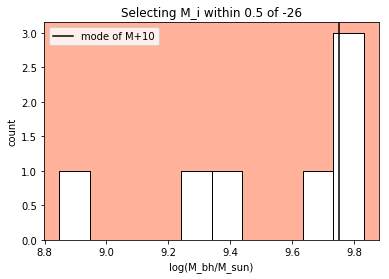

In [275]:
plt.hist(np.log10(cut_28['blackHoleMass'].values), edgecolor='k', color='w')
# SF_inf distribution
b = 'i'

plt.title('Selecting M_i within 0.5 of -26')
plt.xlabel("log(M_bh/M_sun)")
plt.axvline(x=9.75, color='k', label="mode of M+10")
plt.ylabel("count")
#plt.yscale('log', nonposy='clip')
ax = plt.gca()
ax.set_facecolor('xkcd:pale salmon')
plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

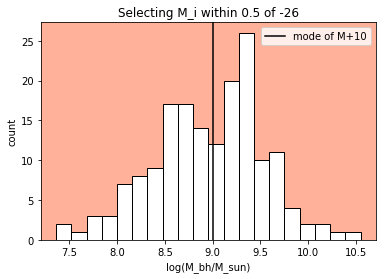

In [278]:
plt.hist(np.log10(cut_26['blackHoleMass'].values), edgecolor='k', color='w', bins=20)
# SF_inf distribution
b = 'i'

plt.title('Selecting M_i within 0.5 of -26')
plt.xlabel("log(M_bh/M_sun)")
plt.axvline(x=9.0, color='k', label="mode of M+10")
plt.ylabel("count")
#plt.yscale('log', nonposy='clip')
ax = plt.gca()
ax.set_facecolor('xkcd:pale salmon')
plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

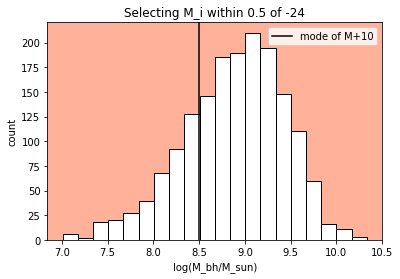

In [277]:
plt.hist(np.log10(cut_24['blackHoleMass'].values), edgecolor='k', color='w', bins=20)
# SF_inf distribution
b = 'i'

plt.title('Selecting M_i within 0.5 of -24')
plt.xlabel("log(M_bh/M_sun)")
plt.axvline(x=8.5, color='k', label="mode of M+10")
plt.ylabel("count")
#plt.yscale('log', nonposy='clip')
ax = plt.gca()
ax.set_facecolor('xkcd:pale salmon')
plt.legend()
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))